# Team Assignment 2  
# HE 381

## Team Members  
1. Abhijeet Bhatta (25169)
2. Ankush Kumar (24033)
3. Chanyanka Kakati (27228) 
4. Suman Dafadar (24139)


## Question 2

Qiskit version: 2.2.0 | Selected backend: qiskit_aer.AerSimulator
Yoshida coefficients (info):
  k=1: base Strang S2 (no s).
  k=2: s = 0.414490771794, 1-4s = -0.657963087178 (NEG)
  k=3: s = 0.373065827733, 1-4s = -0.492263310933 (NEG)
Note: negative middle coefficients for k>1 are expected.

Using AerSimulator (qasm) backend.

=== TASK T1: Build U2, U4, U6 with r slices and show kernel decompositions ===
Model: N=10, J=1.0, h=0.5, r=50, emulate_shots=False
Kernel decompositions used:
  e^{-i theta X}  => H Rz(2*theta) H
  e^{-i theta Z_jZ_{j+1}} => CNOT(j->j+1) Rz(2*theta)_target CNOT(j->j+1)

  U_2k for k=1: qubits=10, depth=771, gates=4200 (built in 0.011s)
  U_2k for k=2: qubits=10, depth=3771, gates=21000 (built in 0.041s)
  U_2k for k=3: qubits=10, depth=18771, gates=105000 (built in 0.160s)

=== TASK T2: Estimate overlaps <psi_k(t) | psi_ref(t)> for k=1,2 and t in [0.1, 0.5, 1.0] ===

--- Time t = 0.1 ---
Built reference U3: depth=18771, gates=105000 (build time 0.161s)

Compar

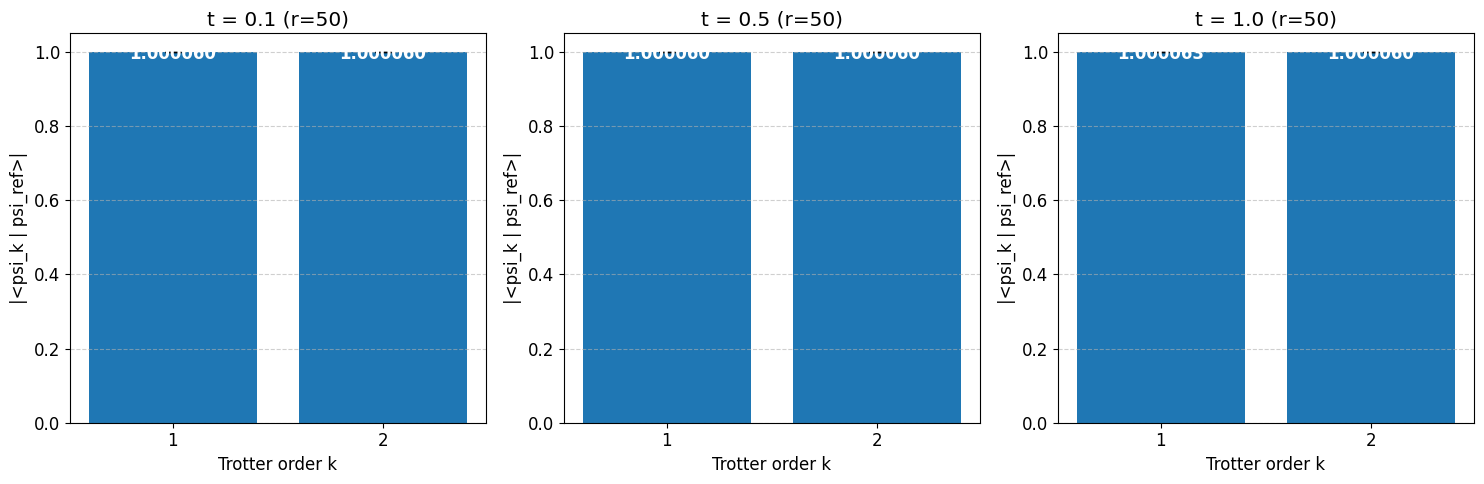

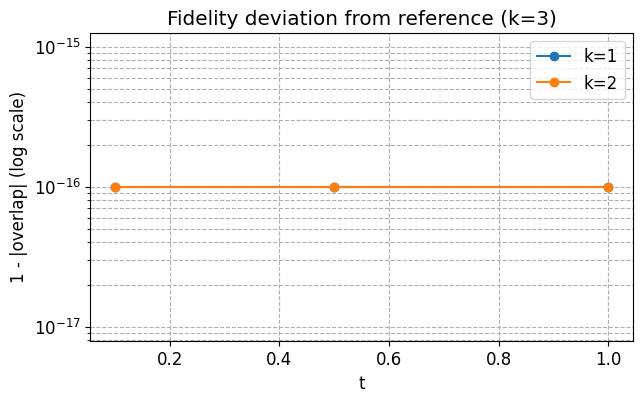


Total runtime: 38.546s
== End ==


In [23]:
# Gate-level TFIM Trotter + Hadamard-test (Fix A)
# Build controlled-U at gate level (no dense .to_gate().control)
# Paste into a fresh Jupyter notebook cell and run.
# Author: pedagogical + robust; intended for assignment T1, T2.

# -------------------------------
# Imports
# -------------------------------
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import qiskit
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector
from functools import lru_cache
from typing import Dict

# -------------------------------
# Backend selection (Aer if available)
# -------------------------------
use_aer = False
backend_name = "local"
try:
    from qiskit.providers.aer import AerSimulator
    backend_name = "qiskit.providers.aer.AerSimulator"
    use_aer = True
except Exception:
    try:
        from qiskit_aer import AerSimulator  # type: ignore
        backend_name = "qiskit_aer.AerSimulator"
        use_aer = True
    except Exception:
        from qiskit.providers.basicaer import QasmSimulator
        backend_name = "qiskit.providers.basicaer.QasmSimulator"
        use_aer = False

print(f"Qiskit version: {qiskit.__version__} | Selected backend: {backend_name}")

# -------------------------------
# Configuration
# -------------------------------
class SimConfig:
    # physics
    N: int = 10
    J: float = 1.0
    h: float = 0.5

    # trotter
    r: int = 50               # assignment uses r=50
    debug: bool = False         # set True to use r_debug
    r_debug: int = 2

    # times for T2
    times: list[float] = [0.1, 0.5, 1.0]

    # shots for hadamard
    shots: int = 8192

    # emulate shots (fast) or run gate-level hadamard (slower)
    emulate_shots: bool = False  # default: run physical gate-level hadamard

    # RNG and reproducibility
    rng_seed: int = 42

config = SimConfig()
if config.debug:
    print("DEBUG mode ON: using smaller r for fast iteration.")
    config.r = config.r_debug

rng = np.random.default_rng(config.rng_seed)

# -------------------------------
# Utility: Yoshida check (informational)
# -------------------------------
def yoshida_s(k):
    if k == 1:
        return None, None
    denom = 4.0 - 4.0 ** (1.0 / (2.0 * k - 1.0))
    s = 1.0 / denom
    return s, 1.0 - 4.0 * s

def print_yoshida_info(max_k=3):
    print("Yoshida coefficients (info):")
    for k in range(1, max_k+1):
        s, v = yoshida_s(k)
        if s is None:
            print(f"  k={k}: base Strang S2 (no s).")
        else:
            print(f"  k={k}: s = {s:.12f}, 1-4s = {v:.12f} ({'NEG' if v<0 else 'POS'})")
    print("Note: negative middle coefficients for k>1 are expected.\n")

print_yoshida_info(3)

# -------------------------------
# Gate-layer builders (kernel-level)
# -------------------------------
@lru_cache(maxsize=256)
def _build_zz_layer(n_qubits: int, theta: float) -> QuantumCircuit:
    """
    Build layer for exp(-i * theta * sum_j Z_j Z_{j+1}) using:
       CNOT(j->j+1); RZ(2*theta) on target; CNOT(j->j+1)
    """
    qc = QuantumCircuit(n_qubits, name=f"ZZ(theta={theta:.6g})")
    for j in range(n_qubits - 1):
        tgt = j + 1
        qc.cx(j, tgt)
        qc.rz(2.0 * theta, tgt)   # RZ(2theta) corresponds to exp(-i theta Z) on that qubit
        qc.cx(j, tgt)
    return qc

@lru_cache(maxsize=256)
def _build_x_layer(n_qubits: int, theta: float) -> QuantumCircuit:
    """
    Build layer for exp(-i * theta * sum X_j) using H RZ(2theta) H on each qubit.
    """
    qc = QuantumCircuit(n_qubits, name=f"X(theta={theta:.6g})")
    for j in range(n_qubits):
        qc.h(j)
        qc.rz(2.0 * theta, j)
        qc.h(j)
    return qc

@lru_cache(maxsize=256)
def _build_s2_step_circuit(n_qubits: int, lam: float, J: float, h: float) -> QuantumCircuit:
    qc = QuantumCircuit(n_qubits, name=f"S2(lam={lam:.6g})")
    qc.compose(_build_zz_layer(n_qubits, J * lam / 2.0), inplace=True)
    qc.compose(_build_x_layer(n_qubits, h * lam), inplace=True)
    qc.compose(_build_zz_layer(n_qubits, J * lam / 2.0), inplace=True)
    return qc

@lru_cache(maxsize=256)
def _build_s2k_step_circuit(n_qubits: int, lam: float, k: int, J: float, h: float) -> QuantumCircuit:
    if k == 1:
        return _build_s2_step_circuit(n_qubits, lam, J, h)
    s = 1.0 / (4.0 - 4.0 ** (1.0 / (2.0 * k - 1.0)))
    qc = QuantumCircuit(n_qubits, name=f"S{2*k}(lam={lam:.6g})")
    inner = _build_s2k_step_circuit(n_qubits, s * lam, k - 1, J, h)
    outer = _build_s2k_step_circuit(n_qubits, (1.0 - 4.0 * s) * lam, k - 1, J, h)
    qc.compose(inner, inplace=True)
    qc.compose(inner, inplace=True)
    qc.compose(outer, inplace=True)
    qc.compose(inner, inplace=True)
    qc.compose(inner, inplace=True)
    return qc

def create_trotter_unitary_circuit(config: SimConfig, t: float, k: int) -> QuantumCircuit:
    lam = t / float(config.r)
    step = _build_s2k_step_circuit(config.N, lam, k, config.J, config.h)
    qc = QuantumCircuit(config.N, name=f"U2k_t{t}_k{k}")
    for _ in range(config.r):
        qc.compose(step, inplace=True)
    return qc

# -------------------------------
# Emulation helper: emulate hadamard shot noise (fast)
# -------------------------------
def emulate_hadamard_shots(exact_overlap: complex, shots: int=8192, rng=None) -> Dict:
    rng_local = rng if rng is not None else np.random.default_rng()
    re = exact_overlap.real
    im = exact_overlap.imag
    p0_re = (1.0 + re) / 2.0
    p0_im = (1.0 + im) / 2.0
    p0_re = min(max(p0_re, 0.0), 1.0)
    p0_im = min(max(p0_im, 0.0), 1.0)
    c0_re = int(rng_local.binomial(shots, p0_re))
    c0_im = int(rng_local.binomial(shots, p0_im))
    est_re = 2.0 * (c0_re / shots) - 1.0
    est_im = 2.0 * (c0_im / shots) - 1.0
    stderr_re = 2.0 * math.sqrt((c0_re / shots) * (1 - c0_re / shots) / shots) if shots>0 else 0.0
    stderr_im = 2.0 * math.sqrt((c0_im / shots) * (1 - c0_im / shots) / shots) if shots>0 else 0.0
    return {
        "est_re": est_re, "est_im": est_im,
        "stderr_re": stderr_re, "stderr_im": stderr_im,
        "counts_re": c0_re, "counts_im": c0_im,
        "p0_re": p0_re, "p0_im": p0_im
    }
def magnitude_error(re: float, im: float, stderr_re: float, stderr_im: float) -> float:
    """
    Proper error propagation for the magnitude of a complex number
    z = re + i*im, with independent errors on re and im.
    """
    mag = math.hypot(re, im)  # sqrt(re^2 + im^2)
    if mag < 1e-12:  # avoid divide by zero
        return math.hypot(stderr_re, stderr_im)
    return math.sqrt((re * stderr_re)**2 + (im * stderr_im)**2) / mag


# -------------------------------
# MAKE CONTROLLED CIRCUIT: gate-level construction
# -------------------------------
def make_controlled_circuit(base_circ: QuantumCircuit, ancilla_qubit: int = 0) -> QuantumCircuit:
    """
    Given a QuantumCircuit 'base_circ' acting on n system qubits (q0..q_{n-1}),
    construct a new circuit acting on (n+1) qubits where qubit 'ancilla_qubit'
    is the control and the remainder are the system (in the same relative order).
    This attempts to convert each primitive instruction to a controlled primitive.
    If an instruction is composite, it tries to decompose and control its primitives.
    This keeps everything at gate-level (no dense matrices).
    """
    # total qubits in new circuit
    n_sys = base_circ.num_qubits
    total_qubits = n_sys + 1
    qc = QuantumCircuit(total_qubits, name=f"c_{base_circ.name}")

    # shift mapping: base qubit idx -> new circuit index (reserve ancilla_qubit)
    # we assume ancilla_qubit==0 for simplicity; if you change this mapping, update indexes accordingly
    if ancilla_qubit != 0:
        raise NotImplementedError("This helper currently supports ancilla_qubit == 0 only.")
    def map_base_to_total(idx):
        return idx + 1  # shift by +1

    # iterate instructions in base_circ.data (works across qiskit versions)
    for inst in base_circ.data:
        # inst can be an Instruction object (with .operation, .qubits) or legacy tuple (op, qargs, cargs)
        if hasattr(inst, "operation"):
            op = inst.operation
            qargs = inst.qubits
        else:
            # legacy structure: (op, qargs, cargs)
            op = inst[0]
            qargs = inst[1]

        # map system qubit indices
        try:
            base_indices = [base_circ.qubits.index(q) for q in qargs]  # indices in original circuit
        except Exception:
            # if something odd happens, fall back to dense
            print("Warning: unexpected qarg structure; falling back to dense controlled gate for safety.")
            dense = base_circ.to_gate().control(1)
            qc.append(dense, list(range(total_qubits)))
            return qc
        sys_qinds = [map_base_to_total(i) for i in base_indices]

        # if op is a classical conditional, we cannot easily handle here
        if getattr(op, "condition", None):
            raise RuntimeError("Controlled construction encountered conditioned instruction (unsupported).")

        # Try direct controlled gate creation from the operation (works for many built-ins)
        try:
            # Some op are Instruction objects that have .to_gate(); some have .control directly.
            ctrl = None
            # prefer op.to_gate().control if available
            if hasattr(op, "to_gate"):
                try:
                    gate = op.to_gate()
                    ctrl = gate.control(1)
                except Exception:
                    ctrl = None
            # fallback to op.control if exists
            if ctrl is None and hasattr(op, "control"):
                try:
                    ctrl = op.control(1)
                except Exception:
                    ctrl = None

            if ctrl is not None:
                qc.append(ctrl, [ancilla_qubit] + sys_qinds)
                continue
        except Exception:
            # Move to decomposition fallback
            pass

        # Decomposition fallback: try to fetch definition and control primitives
        try:
            if hasattr(op, "definition") and op.definition is not None:
                # iterate over decomposition instructions (they belong to the same base_circ qubit ordering)
                for sub in op.definition.data:
                    if hasattr(sub, "operation"):
                        sub_op = sub.operation
                        sub_qargs = sub.qubits
                    else:
                        sub_op = sub[0]
                        sub_qargs = sub[1]
                    # map indices of sub-op in base_circ
                    sub_base_idx = [base_circ.qubits.index(q) for q in sub_qargs]
                    sub_sys_qinds = [map_base_to_total(i) for i in sub_base_idx]
                    # try to control the primitive
                    try:
                        if hasattr(sub_op, "to_gate"):
                            sub_gate = sub_op.to_gate()
                            sub_ctrl = sub_gate.control(1)
                            qc.append(sub_ctrl, [ancilla_qubit] + sub_sys_qinds)
                        elif hasattr(sub_op, "control"):
                            sub_ctrl = sub_op.control(1)
                            qc.append(sub_ctrl, [ancilla_qubit] + sub_sys_qinds)
                        else:
                            # last fallback: append primitive and then convert to controlled using known decompositions
                            # For most primitive single-qubit gates, the to_gate.control approach exists; so reaching here is rare.
                            raise RuntimeError("Cannot build controlled primitive from decomposition.")
                    except Exception:
                        # if we can't control a sub-op, fall back to dense controlled gate for the whole base circ
                        print("Warning: failed to control a decomposition primitive; falling back to dense controlled U.")
                        dense = base_circ.to_gate().control(1)
                        qc.append(dense, list(range(total_qubits)))
                        return qc
                # after finishing decomposition loop, continue with next instruction
                continue
        except Exception:
            # fallback: dense
            print("Warning: decomposition-based fallback failed; using dense controlled gate.")
            dense = base_circ.to_gate().control(1)
            qc.append(dense, list(range(total_qubits)))
            return qc

        # If all attempts failed (unexpected), fall back to dense controlled
        print("Warning: unable to construct controlled version by primitives; falling back to dense controlled U.")
        dense = base_circ.to_gate().control(1)
        qc.append(dense, list(range(total_qubits)))
        return qc

    return qc

# -------------------------------
# Gate-level Hadamard test runner
# -------------------------------
def run_hadamard_test_gatelevel(unitary_circuit: QuantumCircuit, shots: int, backend) -> dict:
    """
    Build and run Hadamard test circuits using gate-level controlled unitary (no dense matrices).
    Ancilla is placed at qubit index 0; system qubits are 1..N.
    Returns dictionary with estimated Re, Im and stderr.
    """
    n_sys = unitary_circuit.num_qubits
    # Build controlled-U at gate-level
    cU = make_controlled_circuit(unitary_circuit, ancilla_qubit=0)

    # Real part circuit
    qc_real = QuantumCircuit(n_sys + 1, 1)
    qc_real.h(0)
    qc_real.append(cU.to_instruction(), list(range(n_sys+1)))  # cU is already full-circuit; append as instruction
    qc_real.h(0)
    qc_real.measure(0, 0)

    # Imag part circuit
    qc_imag = QuantumCircuit(n_sys + 1, 1)
    qc_imag.h(0)
    qc_imag.append(cU.to_instruction(), list(range(n_sys+1)))
    qc_imag.sdg(0)
    qc_imag.h(0)
    qc_imag.measure(0, 0)

    # Transpile minimally
    tqc_real = transpile(qc_real, backend, optimization_level=0)
    tqc_imag = transpile(qc_imag, backend, optimization_level=0)

    # Run
    job_real = backend.run(tqc_real, shots=shots)
    job_imag = backend.run(tqc_imag, shots=shots)
    res_real = job_real.result()
    res_imag = job_imag.result()
    counts_real = res_real.get_counts()
    counts_imag = res_imag.get_counts()

    p0_real = counts_real.get('0', 0) / shots
    p0_imag = counts_imag.get('0', 0) / shots

    est_re = 2 * p0_real - 1
    est_im = 2 * p0_imag - 1

    stderr_re = 2 * math.sqrt(p0_real * (1 - p0_real) / shots)
    stderr_im = 2 * math.sqrt(p0_imag * (1 - p0_imag) / shots)

    return {
        "real": est_re, "imag": est_im,
        "stderr_real": stderr_re, "stderr_imag": stderr_im,
        "counts_real": counts_real, "counts_imag": counts_imag
    }

# -------------------------------
# Plotting helpers
# -------------------------------
def plot_results(df: pd.DataFrame, r_val: int):
    times = sorted(df['t'].unique())
    ncols = len(times)
    fig, axes = plt.subplots(1, ncols, figsize=(5 * ncols, 5), squeeze=False)
    for i, t in enumerate(times):
        ax = axes[0, i]
        subset = df[df['t'] == t].sort_values('k')
        ks = subset['k'].tolist()
        mags = np.abs(subset['estimated_overlap'].tolist())
        errs = subset['estimated_error'].tolist()
        ax.bar(ks, mags, yerr=errs, capsize=6)
        ax.set_title(f't = {t} (r={r_val})')
        ax.set_xlabel('Trotter order k')
        ax.set_ylabel('|<psi_k | psi_ref>|')
        ax.set_xticks(ks)
        ax.set_ylim(0.0, 1.05)
        ax.grid(axis='y', ls='--', alpha=0.6)
        for j, val in enumerate(mags):
            ax.text(ks[j], max(0.01, val - 0.02), f'{val:.6f}', ha='center', color='white', fontweight='bold')
    plt.tight_layout()
    plt.show()

    # fidelity error (log scale)
    plt.figure(figsize=(7,4))
    for k in sorted(df['k'].unique()):
        subset = df[df['k'] == k].sort_values('t')
        ts = subset['t'].tolist()
        errs = [max(1e-16, 1.0 - abs(z)) for z in subset['estimated_overlap'].tolist()]
        plt.plot(ts, errs, marker='o', label=f'k={k}')
    plt.yscale('log')
    plt.xlabel('t')
    plt.ylabel('1 - |overlap| (log scale)')
    plt.title('Fidelity deviation from reference (k=3)')
    plt.grid(True, which='both', ls='--')
    plt.legend()
    plt.show()

# -------------------------------
# MAIN: assignment flow T1 then T2
# -------------------------------
if __name__ == "__main__":
    # backend object
    if use_aer:
        backend = AerSimulator(seed_simulator=config.rng_seed)
        print("Using AerSimulator (qasm) backend.")
    else:
        from qiskit.providers.basicaer import QasmSimulator
        backend = QasmSimulator()
        print("Using QasmSimulator backend.")

    print("\n=== TASK T1: Build U2, U4, U6 with r slices and show kernel decompositions ===")
    print(f"Model: N={config.N}, J={config.J}, h={config.h}, r={config.r}, emulate_shots={config.emulate_shots}")
    print("Kernel decompositions used:")
    print("  e^{-i theta X}  => H Rz(2*theta) H")
    print("  e^{-i theta Z_jZ_{j+1}} => CNOT(j->j+1) Rz(2*theta)_target CNOT(j->j+1)\n")

    for k in [1,2,3]:
        t0 = time.time()
        circ = create_trotter_unitary_circuit(config, t=0.1, k=k)
        print(f"  U_2k for k={k}: qubits={circ.num_qubits}, depth={circ.depth()}, gates={circ.size()} (built in {time.time()-t0:.3f}s)")

    print("\n=== TASK T2: Estimate overlaps <psi_k(t) | psi_ref(t)> for k=1,2 and t in", config.times, "===\n")
    results = []
    start_all = time.time()
    for t in config.times:
        print(f"--- Time t = {t} ---")
        t0 = time.time()
        U3 = create_trotter_unitary_circuit(config, t, k=3)
        print(f"Built reference U3: depth={U3.depth()}, gates={U3.size()} (build time {time.time()-t0:.3f}s)")

        for k in [1,2]:
            print(f"\nComparing k={k} vs k=3 ...")
            t0 = time.time()
            Uk = create_trotter_unitary_circuit(config, t, k=k)
            print(f"  Built Uk: depth={Uk.depth()}, gates={Uk.size()} (build time {time.time()-t0:.3f}s)")

            # correct: apply U3 then Uk^{-1} so the operator is U_k^{-1} @ U3
            total_unitary = U3.compose(Uk.inverse())


            # optional expensive sanity check (only in debug mode)
            if config.debug:
                try:
                    from qiskit.quantum_info import Operator
                    op = Operator(total_unitary)
                    print("  Sanity: Operator.is_unitary() =", op.is_unitary())
                except Exception as e:
                    print("  Sanity check failed:", e)

            # exact overlap via statevectors
            psi3 = Statevector.from_instruction(U3)
            psik = Statevector.from_instruction(Uk)
            exact_overlap = np.vdot(psik.data, psi3.data)
            print(f"  Exact overlap: Re={exact_overlap.real:+.8e}, Im={exact_overlap.imag:+.8e}, |ov|={abs(exact_overlap):.12e}")

            # either emulate shots (fast) or run gate-level hadamard (physical but gate-level)
            if config.emulate_shots:
                em = emulate_hadamard_shots(exact_overlap, shots=config.shots, rng=rng)
                est_re, est_im = em["est_re"], em["est_im"]
                stderr_re, stderr_im = em["stderr_re"], em["stderr_im"]
                print(f"  Emulated Hadamard (shots={config.shots}): Re={est_re:+.6f} ± {stderr_re:.6f}, Im={est_im:+.6f} ± {stderr_im:.6f}")
            else:
                print("  Running gate-level Hadamard test (this will be slower but avoids dense matrices)...")
                had = run_hadamard_test_gatelevel(total_unitary, shots=config.shots, backend=backend)
                est_re, est_im = had["real"], had["imag"]
                stderr_re, stderr_im = had["stderr_real"], had["stderr_imag"]
                print(f"  Gate-level Hadamard: Re={est_re:+.6f} ± {stderr_re:.6f}, Im={est_im:+.6f} ± {stderr_im:.6f}")

                overlap_est = est_re + 1j * est_im
                combined_err = magnitude_error(est_re, est_im, stderr_re, stderr_im)

            results.append({
                "t": t,
                "k": k,
                "estimated_overlap": overlap_est,
                "estimated_error": combined_err,
                "exact_overlap": exact_overlap
            })

    df = pd.DataFrame(results)
    print("\n=== Final results (table) ===")
    if df.empty:
        print("No results recorded.")
    else:
        df2 = df.copy()
        df2["est_re"] = df2["estimated_overlap"].apply(lambda z: z.real)
        df2["est_im"] = df2["estimated_overlap"].apply(lambda z: z.imag)
        df2["exact_re"] = df2["exact_overlap"].apply(lambda z: z.real)
        df2["exact_im"] = df2["exact_overlap"].apply(lambda z: z.imag)
        cols = ["t","k","est_re","est_im","estimated_error","exact_re","exact_im"]
        print(df2[cols].to_string(index=False, float_format="{:.8f}".format))

    # plotting
    if not df.empty:
        plot_results(df, config.r)

    print(f"\nTotal runtime: {time.time() - start_all:.3f}s")
    print("== End ==")


Running T2: r = 50, times = [0.1, 0.5, 1.0], shots = 8192

--- t = 0.1 ---
k=1  | exact: Re=+1.00000000e+00, Im=-5.88797840e-07, |ov|=9.999999999962e-01
     emulated shots -> Re=+1.000000 ± 0.000000, Im=+0.000000 ± 0.011049  | |ov|=1.00000000 ± 0.00000000
k=2  | exact: Re=+1.00000000e+00, Im=+2.13828955e-13, |ov|=9.999999999959e-01
     emulated shots -> Re=+1.000000 ± 0.000000, Im=-0.001709 ± 0.011049  | |ov|=1.00000146 ± 0.00001888

--- t = 0.5 ---
k=1  | exact: Re=+9.99999998e-01, Im=-4.83945232e-05, |ov|=9.999999988969e-01
     emulated shots -> Re=+1.000000 ± 0.000000, Im=+0.023926 ± 0.011045  | |ov|=1.00028618 ± 0.00026419
k=2  | exact: Re=+1.00000000e+00, Im=+3.23767110e-10, |ov|=9.999999999977e-01
     emulated shots -> Re=+1.000000 ± 0.000000, Im=+0.003662 ± 0.011048  | |ov|=1.00000671 ± 0.00004046

--- t = 1.0 ---
k=1  | exact: Re=+9.99999957e-01, Im=-2.18102726e-04, |ov|=9.999999803034e-01
     emulated shots -> Re=+1.000000 ± 0.000000, Im=-0.001953 ± 0.011049  | |ov|=1.000

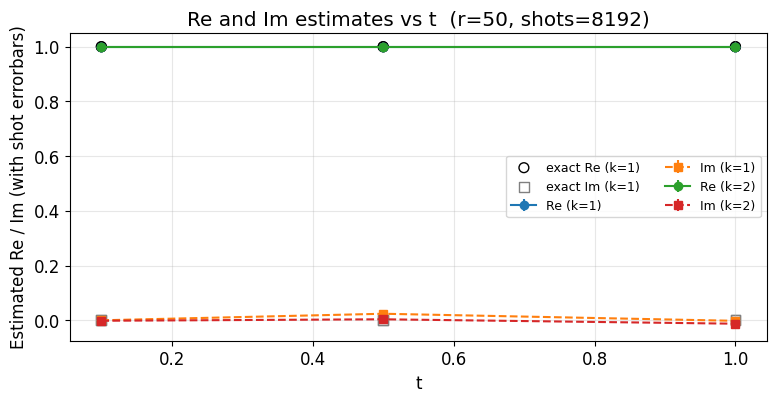

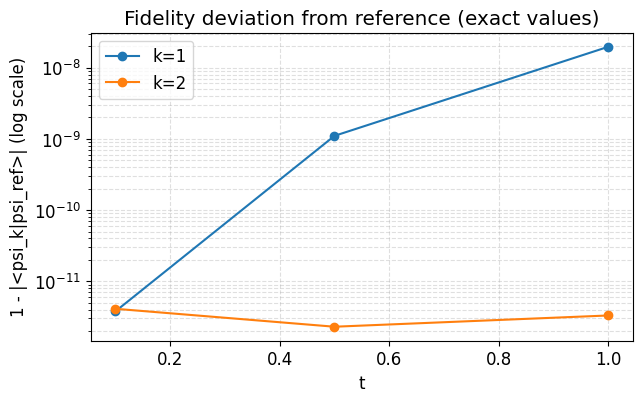


=== Brief automated observations ===
k=1: mean fidelity deviation (exact) = 6.934e-09, max deviation = 1.970e-08
k=2: mean fidelity deviation (exact) = 3.239e-12, max deviation = 4.108e-12

Notes for report:
 - Exact overlaps (statevector) show the pure Trotter/Suzuki error.
 - Emulated shot errorbars show realistic measurement/statistical uncertainty for given shots.
 - For large r (e.g. r=50) expect extremely small Trotter errors (overlaps ≈ 1).
 - For smaller r (e.g. r=2) the difference between orders is visible and follows the expected scaling.


In [24]:
# --- Cell: T2 experiment (corrected) ---
# Build U_k, compute exact overlaps, emulate Hadamard shots (with proper mag error),
# optional single gate-level verify. Paste into fresh cell and run.
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from qiskit.quantum_info import Statevector

# --- USER CONTROL ---
r_val = config.r             # uses config from previous cell (should be 50 for assignment)
times = config.times         # [0.1, 0.5, 1.0]
ks_to_test = [1, 2]          # k=1,2 as required
k_ref = 3                    # comparison k=3
shots = config.shots
rng_local = np.random.default_rng(config.rng_seed + 123)

# If True, run one gate-level hadamard for each (t,k) to verify emulation (VERY SLOW)
run_one_gate_level_verify = False

# --- helper: magnitude error propagation ---
def magnitude_error(re: float, im: float, stderr_re: float, stderr_im: float) -> float:
    """
    Proper error propagation for the magnitude |z| = sqrt(re^2 + im^2)
    given independent standard errors on re and im.
    """
    mag = math.hypot(re, im)
    if mag < 1e-12:
        # If magnitude ~ 0, return quadrature of the components' errors as a conservative fallback
        return math.hypot(stderr_re, stderr_im)
    return math.sqrt((re * stderr_re)**2 + (im * stderr_im)**2) / mag

# --- storage ---
rows = []

# helper to pretty-print complex with +/- err
def fmt_est(re, im, err_re, err_im):
    return f"Re={re:+.6f} ± {err_re:.6f}, Im={im:+.6f} ± {err_im:.6f}"

print(f"Running T2: r = {r_val}, times = {times}, shots = {shots}\n")
for t in times:
    print(f"--- t = {t} ---")
    # Build reference U3 (k=3) once per time
    U3 = create_trotter_unitary_circuit(config, t, k=k_ref)
    sv_ref = Statevector.from_instruction(U3)

    for k in ks_to_test:
        # Build Uk and exact statevectors
        Uk = create_trotter_unitary_circuit(config, t, k=k)
        sv_k = Statevector.from_instruction(Uk)

        # exact overlap <psi_k | psi_ref>
        exact = np.vdot(sv_k.data, sv_ref.data)
        exact_re, exact_im = float(exact.real), float(exact.imag)
        exact_mag = abs(exact)

        # emulate hadamard shot sampling (fast)
        em = emulate_hadamard_shots(exact, shots=shots, rng=rng_local)
        est_re, est_im = em["est_re"], em["est_im"]
        stderr_re, stderr_im = em["stderr_re"], em["stderr_im"]

        # optionally run a single gate-level hadamard (very slow) for verification
        gatelevel_info = None
        if run_one_gate_level_verify:
            try:
                # correct composition: apply U3 then Uk.inverse() so operator = Uk^{-1} @ U3
                total_unitary = U3.compose(Uk.inverse())
                if use_aer:
                    from qiskit.providers.aer import AerSimulator
                    backend_verify = AerSimulator(seed_simulator=config.rng_seed)
                else:
                    backend_verify = None
                # run_hadamard_test_gatelevel expects a backend object; if not available we skip
                if backend_verify is None:
                    gatelevel_info = {"error": "No Aer backend available for gate-level verify."}
                else:
                    had = run_hadamard_test_gatelevel(total_unitary, shots=shots, backend=backend_verify)
                    gatelevel_info = {
                        "re": had["real"], "im": had["imag"],
                        "stderr_re": had["stderr_real"], "stderr_im": had["stderr_imag"]
                    }
            except Exception as e:
                gatelevel_info = {"error": str(e)}

        # combined magnitude error (proper propagation)
        mag_err = magnitude_error(est_re, est_im, stderr_re, stderr_im)

        rows.append({
            "t": t, "k": k,
            "exact_re": exact_re, "exact_im": exact_im, "exact_mag": exact_mag,
            "est_re": est_re, "est_im": est_im,
            "stderr_re": stderr_re, "stderr_im": stderr_im,
            "est_mag": abs(est_re + 1j*est_im), "est_mag_err": mag_err,
            "gate_verify": gatelevel_info
        })

        # print summary line for quick eyeballing
        print(f"k={k:1d}  | exact: Re={exact_re:+.8e}, Im={exact_im:+.8e}, |ov|={exact_mag:.12e}")
        print(f"     emulated shots -> {fmt_est(est_re, est_im, stderr_re, stderr_im)}  | |ov|={abs(est_re+1j*est_im):.8f} ± {mag_err:.8f}")
        if gatelevel_info is not None:
            print("     gate-level verify:", gatelevel_info)
    print()

# --- Results DataFrame and table printout ---
df = pd.DataFrame(rows)
display_cols = ["t","k","est_re","stderr_re","est_im","stderr_im","est_mag","est_mag_err","exact_re","exact_im","exact_mag"]
print("\n=== Results table (estimates with shot emulation + exact overlaps) ===")
pd.options.display.float_format = "{:.8e}".format
print(df[display_cols].to_string(index=False))

# --- Plot: Re & Im vs t with errorbars for k=1,2 ---
fig, ax = plt.subplots(1,1, figsize=(9,4))
for k in ks_to_test:
    sub = df[df["k"]==k].sort_values("t")
    ax.errorbar(sub["t"], sub["est_re"], yerr=sub["stderr_re"], marker='o', linestyle='-', label=f"Re (k={k})")
    ax.errorbar(sub["t"], sub["est_im"], yerr=sub["stderr_im"], marker='s', linestyle='--', label=f"Im (k={k})")
    # overlay exact Re/Im as hollow markers
    ax.scatter(sub["t"], sub["exact_re"], marker='o', facecolors='none', edgecolors='black', s=50, label=f"exact Re (k={k})" if k==ks_to_test[0] else "")
    ax.scatter(sub["t"], sub["exact_im"], marker='s', facecolors='none', edgecolors='gray', s=50, label=f"exact Im (k={k})" if k==ks_to_test[0] else "")

ax.set_xlabel('t')
ax.set_ylabel('Estimated Re / Im (with shot errorbars)')
ax.set_title(f'Re and Im estimates vs t  (r={r_val}, shots={shots})')
ax.legend(ncol=2, fontsize=9)
ax.grid(alpha=0.3)
plt.show()

# --- Plot: Fidelity deviation 1 - |ov| (log scale) [exact statevector values] ---
plt.figure(figsize=(7,4))
for k in ks_to_test:
    sub = df[df["k"]==k].sort_values("t")
    dev = 1.0 - sub["exact_mag"]
    plt.plot(sub["t"], dev, marker='o', label=f'k={k}')
plt.yscale('log')
plt.xlabel('t')
plt.ylabel('1 - |<psi_k|psi_ref>| (log scale)')
plt.title('Fidelity deviation from reference (exact values)')
plt.grid(True, which='both', ls='--', alpha=0.4)
plt.legend()
plt.show()

# --- Short automated observations printed for convenience ---
print("\n=== Brief automated observations ===")
for k in ks_to_test:
    sub = df[df["k"]==k]
    mean_dev = (1.0 - sub["exact_mag"]).mean()
    max_dev = (1.0 - sub["exact_mag"]).max()
    print(f"k={k}: mean fidelity deviation (exact) = {mean_dev:.3e}, max deviation = {max_dev:.3e}")
print("\nNotes for report:")
print(" - Exact overlaps (statevector) show the pure Trotter/Suzuki error.")
print(" - Emulated shot errorbars show realistic measurement/statistical uncertainty for given shots.")
print(" - For large r (e.g. r=50) expect extremely small Trotter errors (overlaps ≈ 1).")
print(" - For smaller r (e.g. r=2) the difference between orders is visible and follows the expected scaling.")


Built dense Hamiltonian H with shape (1024, 1024) (N=10)

=== Table: exact-reference fidelity deviations (no Trotter error in reference) ===
t     1.000e-01  5.000e-01  1.000e+00
r  k                                 
2  1  3.590e-08  4.602e-04  9.802e-03
   2  2.565e-14  3.753e-08  5.435e-06
5  1  9.170e-10  1.113e-05  2.044e-04
   2  2.065e-14  2.242e-11  2.851e-09
10 1  5.732e-11  6.898e-07  1.242e-05
   2  4.841e-14  1.676e-13  1.089e-11
50 1  1.723e-13  1.101e-09  1.969e-08
   2  5.127e-13  2.454e-13  1.780e-13


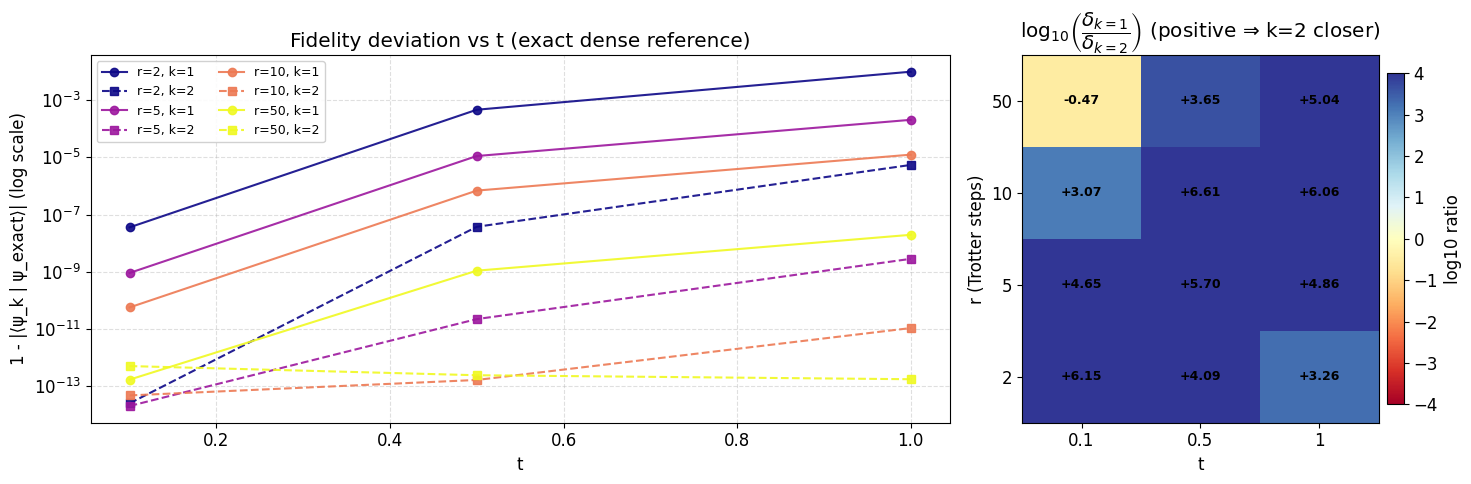


=== Summary (positive log10 => k=2 is closer to exact) ===
r=2:
  t= 0.1: log10(delta1/delta2) = +6.146  => k2 closer
  t= 0.5: log10(delta1/delta2) = +4.089  => k2 closer
  t= 1.0: log10(delta1/delta2) = +3.256  => k2 closer
r=5:
  t= 0.1: log10(delta1/delta2) = +4.647  => k2 closer
  t= 0.5: log10(delta1/delta2) = +5.696  => k2 closer
  t= 1.0: log10(delta1/delta2) = +4.855  => k2 closer
r=10:
  t= 0.1: log10(delta1/delta2) = +3.073  => k2 closer
  t= 0.5: log10(delta1/delta2) = +6.614  => k2 closer
  t= 1.0: log10(delta1/delta2) = +6.057  => k2 closer
r=50:
  t= 0.1: log10(delta1/delta2) = -0.474  => k1 closer
  t= 0.5: log10(delta1/delta2) = +3.652  => k2 closer
  t= 1.0: log10(delta1/delta2) = +5.044  => k2 closer


In [25]:
# --- Cell: T3 exact-evolution reference + beautiful visualizations ---
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from functools import reduce
import scipy.linalg
from qiskit.quantum_info import Statevector

# -----------------------------
# User controls (edit if desired)
# -----------------------------
times = config.times[:]               # [0.1, 0.5, 1.0]
r_list = [2, 5, 10, 50]               # Trotter step counts to compare (multiple r in one run)
ks = [1, 2]                           # Trotter orders to evaluate vs exact
k_ref = None                          # unused here (we use exact U)
N = config.N
J = config.J
h = config.h

# numerical floor for logs
EPS = 1e-20

# -----------------------------
# Build full Hamiltonian H (dense)
# -----------------------------
# Pauli matrices (float64 complex)
X = np.array([[0.,1.],[1.,0.]], dtype=complex)
Z = np.array([[1.,0.],[0.,-1.]], dtype=complex)
I2 = np.eye(2, dtype=complex)

def kron_list(mats):
    """Tensor product: left-most matrix corresponds to highest-order qubit in basis ordering.
       This matches the ordering used elsewhere in the notebook (|q_N ... q_1>).
    """
    return reduce(np.kron, mats)

dim = 2**N
H = np.zeros((dim, dim), dtype=complex)

# Build nearest-neighbour Z_j Z_{j+1} terms (j runs 0..N-2)
for j in range(N-1):
    mats = []
    for q in range(N):
        if q == j:
            mats.append(Z)
        elif q == j+1:
            mats.append(Z)
        else:
            mats.append(I2)
    H += J * kron_list(mats)

# Build transverse field terms h * X_j
for j in range(N):
    mats = []
    for q in range(N):
        if q == j:
            mats.append(X)
        else:
            mats.append(I2)
    H += h * kron_list(mats)

print(f"Built dense Hamiltonian H with shape {H.shape} (N={N})")

# initial state |00...0> in computational basis
psi0 = np.zeros((dim,), dtype=complex)
psi0[0] = 1.0

# -----------------------------
# Compute overlaps for multiple r, ks and times (exact reference)
# -----------------------------
rows = []
# We'll temporarily change config.r when building trotter circuits; restore after loop
config_r_old = config.r

for r in r_list:
    config.r = r
    for t in times:
        # exact U and exact state (no Trotter error)
        U_exact = scipy.linalg.expm(-1j * H * t)
        psi_exact = U_exact.dot(psi0)             # exact evolved statevector (dense)
        # optional: sv_exact = Statevector(psi_exact)  # only if you need qiskit object

        for k in ks:
            # build Trotter statevector from circuit (uses current config.r)
            Uk = create_trotter_unitary_circuit(config, t, k=k)
            sv_k = Statevector.from_instruction(Uk)

            # overlap <psi_k | psi_exact>
            ov = np.vdot(sv_k.data, psi_exact)
            dev = max(0.0, 1.0 - abs(ov))   # fidelity deviation (non-negative)
            rows.append({
                "r": r, "t": t, "k": k,
                "ov": ov, "dev": dev,
                "ov_re": float(ov.real), "ov_im": float(ov.imag)
            })

# restore config.r
config.r = config_r_old

df = pd.DataFrame(rows)

# -----------------------------
# Nicely formatted results table (exact-reference)
# -----------------------------
pd.options.display.float_format = "{:.3e}".format
print("\n=== Table: exact-reference fidelity deviations (no Trotter error in reference) ===")
print(df.pivot_table(index=['r','k'], columns='t', values='dev').to_string())

# -----------------------------
# Visualization 1: dev vs t (log scale), multiple r and k in one figure
# -----------------------------
plt.rcParams.update({'font.size': 12})
fig, axes = plt.subplots(1, 2, figsize=(15,5), gridspec_kw={'width_ratios':[2,1]})

ax = axes[0]
colors = plt.cm.plasma(np.linspace(0,1,len(r_list)))
for i, r in enumerate(r_list):
    for k, marker, ls in [(1,'o','-'), (2,'s','--')]:
        sub = df[(df['r']==r) & (df['k']==k)].sort_values('t')
        devs = sub['dev'].values
        devs_plot = np.clip(devs, EPS, None)
        label = f"r={r}, k={k}"
        ax.plot(sub['t'], devs_plot, marker=marker, linestyle=ls, color=colors[i], label=label, alpha=0.9)

ax.set_yscale('log')
ax.set_xlabel('t')
ax.set_ylabel('1 - |⟨ψ_k | ψ_exact⟩| (log scale)')
ax.set_title('Fidelity deviation vs t (exact dense reference)')
ax.grid(True, which='both', ls='--', alpha=0.4)
# compact legend
ax.legend(ncol=2, fontsize=9, framealpha=0.9)

# -----------------------------
# Visualization 2: heatmap of log10(dev1/dev2) (rows=r, cols=t)
# -----------------------------
r_vals = sorted(df['r'].unique())
t_vals = sorted(df['t'].unique())
ratio_matrix = np.zeros((len(r_vals), len(t_vals)))

for i, r in enumerate(r_vals):
    for j, t in enumerate(t_vals):
        d1 = float(df[(df['r']==r) & (df['t']==t) & (df['k']==1)]['dev'].values[0])
        d2 = float(df[(df['r']==r) & (df['t']==t) & (df['k']==2)]['dev'].values[0])
        d1c = max(d1, EPS)
        d2c = max(d2, EPS)
        ratio_matrix[i,j] = math.log10(d1c / d2c)

ax2 = axes[1]
im = ax2.imshow(ratio_matrix, origin='lower', cmap='RdYlBu', aspect='auto', vmin=-4, vmax=4)
ax2.set_xticks(range(len(t_vals))); ax2.set_xticklabels([f"{tv:.2g}" for tv in t_vals])
ax2.set_yticks(range(len(r_vals))); ax2.set_yticklabels([str(rv) for rv in r_vals])
ax2.set_xlabel('t')
ax2.set_ylabel('r (Trotter steps)')
ax2.set_title(r'$\log_{10}\!\left(\dfrac{\delta_{k=1}}{\delta_{k=2}}\right)$ (positive ⇒ k=2 closer)')
cbar = fig.colorbar(im, ax=ax2, shrink=0.9, pad=0.02)
cbar.set_label('log10 ratio')

# Annotate numeric log10 values on heatmap
for i in range(len(r_vals)):
    for j in range(len(t_vals)):
        txt = f"{ratio_matrix[i,j]:+.2f}"
        ax2.text(j, i, txt, ha='center', va='center', color='black', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# -----------------------------
# Quick printed summary (human-friendly)
# -----------------------------
print("\n=== Summary (positive log10 => k=2 is closer to exact) ===")
for i, r in enumerate(r_vals):
    print(f"r={r}:")
    for j, t in enumerate(t_vals):
        val = ratio_matrix[i,j]
        relation = "k2 closer" if val>0 else ("k1 closer" if val<0 else "equal (within numerical noise)")
        print(f"  t={t:>4}: log10(delta1/delta2) = {val:+.3f}  => {relation}")

# -----------------------------
# Optional: put results DataFrame into variable df_exact_t3 for later use
# -----------------------------
df_exact_t3 = df.copy()



=== TASK T1: Build U2, U4, U6 with r slices and show kernel decompositions ===
Model: N=10, J=1.0, h=0.5, r=50
Kernel decompositions used:
  e^{-i theta X}  => H Rz(2*theta) H
  e^{-i theta Z_jZ_{j+1}} => CNOT(j->j+1) Rz(2*theta)_target CNOT(j->j+1)

  U_2k for k=1: qubits=10, depth=771, gates=4200 (built in 0.014s)
  U_2k for k=2: qubits=10, depth=3771, gates=21000 (built in 0.048s)
  U_2k for k=3: qubits=10, depth=18771, gates=105000 (built in 0.166s)

=== TASK T2: GHZ initial state overlaps <psi_k | psi_ref> for k=1,2 ===

Using AerSimulator (qiskit_aer).
--- Time t = 0.1 ---

Comparing k=1 vs k=3 ...
  Exact overlap: Re=+9.999999999960e-01, Im=-5.887978535846e-07, |ov|=9.999999999962e-01
  Running gate-level Hadamard test (this will be slower but avoids dense matrices)...
  Gate-level Hadamard: Re=+1.000000 ± 0.000000, Im=+0.010742 ± 0.011048

Comparing k=2 vs k=3 ...
  Exact overlap: Re=+9.999999999959e-01, Im=+1.934008508897e-13, |ov|=9.999999999959e-01
  Running gate-level Hada

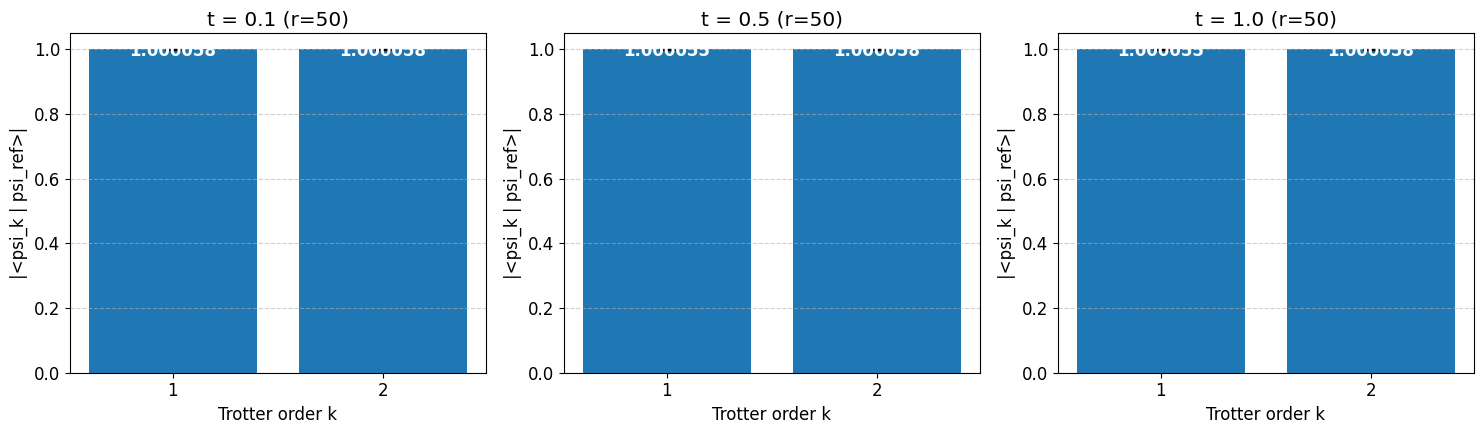

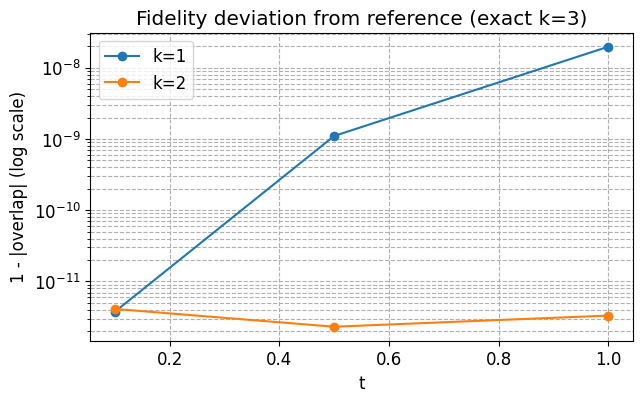


Total runtime (T1+T2 GHZ): 34.041s
== End of GHZ T1/T2 ==


In [27]:
# --- T1 + T2 for GHZ initial state (robust backend selection) ---
import time, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from qiskit import transpile
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit

# -----------------------------
# Helper: GHZ preparation circuit
# -----------------------------
def ghz_prep_circuit(n_qubits: int) -> QuantumCircuit:
    """Prepare (|00...0> + |11...1>)/sqrt(2) using H on qubit 0 then chain of CNOTs."""
    qc = QuantumCircuit(n_qubits, name="GHZ_prep")
    if n_qubits == 0:
        return qc
    qc.h(0)
    for j in range(n_qubits - 1):
        qc.cx(j, j + 1)
    return qc

# -----------------------------
# Helper: hadamard test that supports a system state-prep circuit
# -----------------------------
def run_hadamard_with_prep(total_unitary: QuantumCircuit, prep_circ: QuantumCircuit, shots: int, backend) -> dict:
    """
    Build and run Hadamard test circuits for <prep| Uk^dagger U3 |prep> by:
      - preparing the 'prep_circ' on system qubits (indices 1..n)
      - performing ancilla H, controlled-(total_unitary), H, measure ancilla
    total_unitary: QuantumCircuit acting on n system qubits (0..n-1)
    prep_circ: QuantumCircuit acting on n system qubits (same ordering)
    backend: Qiskit qasm simulator backend object (or AerSimulator)
    """
    n_sys = total_unitary.num_qubits
    total_q = n_sys + 1
    # build controlled version
    cU = make_controlled_circuit(total_unitary, ancilla_qubit=0)

    # Real part circuit
    qc_real = QuantumCircuit(total_q, 1)
    # insert prep on system qubits 1..n
    qc_real.compose(prep_circ, qubits=list(range(1, total_q)), inplace=True)
    qc_real.h(0)
    qc_real.append(cU.to_instruction(), list(range(total_q)))
    qc_real.h(0)
    qc_real.measure(0, 0)

    # Imag part circuit
    qc_imag = QuantumCircuit(total_q, 1)
    qc_imag.compose(prep_circ, qubits=list(range(1, total_q)), inplace=True)
    qc_imag.h(0)
    qc_imag.append(cU.to_instruction(), list(range(total_q)))
    qc_imag.sdg(0)
    qc_imag.h(0)
    qc_imag.measure(0, 0)

    # Transpile minimally
    tqc_real = transpile(qc_real, backend, optimization_level=0)
    tqc_imag = transpile(qc_imag, backend, optimization_level=0)

    # Run
    job_real = backend.run(tqc_real, shots=shots)
    job_imag = backend.run(tqc_imag, shots=shots)
    res_real = job_real.result()
    res_imag = job_imag.result()
    counts_real = res_real.get_counts()
    counts_imag = res_imag.get_counts()

    p0_real = counts_real.get('0', 0) / shots
    p0_imag = counts_imag.get('0', 0) / shots

    est_re = 2 * p0_real - 1
    est_im = 2 * p0_imag - 1

    stderr_re = 2 * math.sqrt(p0_real * (1 - p0_real) / shots)
    stderr_im = 2 * math.sqrt(p0_imag * (1 - p0_imag) / shots)

    return {
        "real": est_re, "imag": est_im,
        "stderr_real": stderr_re, "stderr_imag": stderr_im,
        "counts_real": counts_real, "counts_imag": counts_imag
    }

# -----------------------------
# Setup & T1 (same style as before)
# -----------------------------
print("\n=== TASK T1: Build U2, U4, U6 with r slices and show kernel decompositions ===")
print(f"Model: N={config.N}, J={config.J}, h={config.h}, r={config.r}")
print("Kernel decompositions used:")
print("  e^{-i theta X}  => H Rz(2*theta) H")
print("  e^{-i theta Z_jZ_{j+1}} => CNOT(j->j+1) Rz(2*theta)_target CNOT(j->j+1)\n")

for k in [1, 2, 3]:
    t0 = time.time()
    circ = create_trotter_unitary_circuit(config, t=0.1, k=k)
    print(f"  U_2k for k={k}: qubits={circ.num_qubits}, depth={circ.depth()}, gates={circ.size()} (built in {time.time()-t0:.3f}s)")

# -----------------------------
# T2: GHZ initial state experiments (compare k=1,2 to k=3)
# -----------------------------
print("\n=== TASK T2: GHZ initial state overlaps <psi_k | psi_ref> for k=1,2 ===\n")

# --- robust backend selection (try both aer names, else BasicAer) ---
backend = None
if use_aer:
    try:
        from qiskit.providers.aer import AerSimulator
        backend = AerSimulator(seed_simulator=config.rng_seed)
        print("Using AerSimulator (qiskit.providers.aer).")
    except Exception:
        try:
            from qiskit_aer import AerSimulator  # some installs expose this
            backend = AerSimulator(seed_simulator=config.rng_seed)
            print("Using AerSimulator (qiskit_aer).")
        except Exception:
            # fallback to basic qasm
            try:
                from qiskit.providers.basicaer import QasmSimulator
                backend = QasmSimulator()
                print("Aer not available; falling back to QasmSimulator (BasicAer).")
            except Exception:
                backend = None
else:
    try:
        from qiskit.providers.basicaer import QasmSimulator
        backend = QasmSimulator()
        print("Using QasmSimulator (BasicAer).")
    except Exception:
        backend = None

if backend is None:
    print("No local qasm simulator found. Switching to emulated-shot mode (fast) for Hadamard estimates.")
    config.emulate_shots = True

# prepare GHZ prep circ
ghz = ghz_prep_circuit(config.N)

results = []
rng_local = np.random.default_rng(config.rng_seed + 1)

start_all = time.time()
for t in config.times:
    print(f"--- Time t = {t} ---")
    # build U3 (reference) and combined reference state psi3 = U3 * GHZ
    U3 = create_trotter_unitary_circuit(config, t, k=3)
    combined_ref = QuantumCircuit(config.N)
    combined_ref.compose(ghz, inplace=True)
    combined_ref.compose(U3, inplace=True)
    psi3 = Statevector.from_instruction(combined_ref)

    for k in [1, 2]:
        print(f"\nComparing k={k} vs k=3 ...")
        Uk = create_trotter_unitary_circuit(config, t, k=k)
        combined_k = QuantumCircuit(config.N)
        combined_k.compose(ghz, inplace=True)
        combined_k.compose(Uk, inplace=True)
        psik = Statevector.from_instruction(combined_k)

        # exact overlap via statevectors
        exact_overlap = np.vdot(psik.data, psi3.data)
        print(f"  Exact overlap: Re={exact_overlap.real:+.12e}, Im={exact_overlap.imag:+.12e}, |ov|={abs(exact_overlap):.12e}")

        # either emulate shots (fast) or run gate-level hadamard (physical but slow)
        if config.emulate_shots or backend is None:
            em = emulate_hadamard_shots(exact_overlap, shots=config.shots, rng=rng_local)
            est_re, est_im = em["est_re"], em["est_im"]
            stderr_re, stderr_im = em["stderr_re"], em["stderr_im"]
            print(f"  Emulated Hadamard (shots={config.shots}): Re={est_re:+.6f} ± {stderr_re:.6f}, Im={est_im:+.6f} ± {stderr_im:.6f}")
        else:
            # Build total_unitary = U3.compose(Uk.inverse())  (acts on system qubits 0..N-1)
            total_unitary = U3.compose(Uk.inverse())
            print("  Running gate-level Hadamard test (this will be slower but avoids dense matrices)...")
            had = run_hadamard_with_prep(total_unitary, ghz, shots=config.shots, backend=backend)
            est_re, est_im = had["real"], had["imag"]
            stderr_re, stderr_im = had["stderr_real"], had["stderr_imag"]
            print(f"  Gate-level Hadamard: Re={est_re:+.6f} ± {stderr_re:.6f}, Im={est_im:+.6f} ± {stderr_im:.6f}")

        overlap_est = est_re + 1j * est_im
        combined_err = magnitude_error(est_re, est_im, stderr_re, stderr_im)

        results.append({
            "t": t,
            "k": k,
            "estimated_overlap": overlap_est,
            "estimated_error": combined_err,
            "exact_overlap": exact_overlap
        })

# assemble dataframe and print
df = pd.DataFrame(results)
if df.empty:
    print("No results recorded.")
else:
    df2 = df.copy()
    df2["est_re"] = df2["estimated_overlap"].apply(lambda z: z.real)
    df2["est_im"] = df2["estimated_overlap"].apply(lambda z: z.imag)
    df2["exact_re"] = df2["exact_overlap"].apply(lambda z: z.real)
    df2["exact_im"] = df2["exact_overlap"].apply(lambda z: z.imag)
    cols = ["t","k","est_re","est_im","estimated_error","exact_re","exact_im"]
    pd.options.display.float_format = "{:.8e}".format
    print("\n=== Final results (table) ===")
    print(df2[cols].to_string(index=False))

# -----------------------------
# Visualization (same style as prior)
# -----------------------------
def plot_results_g(df: pd.DataFrame, r_val: int):
    times = sorted(df['t'].unique())
    ncols = len(times)
    fig, axes = plt.subplots(1, ncols, figsize=(5 * ncols, 4.5), squeeze=False)
    for i, t in enumerate(times):
        ax = axes[0, i]
        subset = df[df['t'] == t].sort_values('k')
        ks = subset['k'].tolist()
        mags = np.abs(subset['estimated_overlap'].tolist())
        errs = subset['estimated_error'].tolist()
        ax.bar(ks, mags, yerr=errs, capsize=6)
        ax.set_title(f't = {t} (r={r_val})')
        ax.set_xlabel('Trotter order k')
        ax.set_ylabel('|<psi_k | psi_ref>|')
        ax.set_xticks(ks)
        ax.set_ylim(0.0, 1.05)
        ax.grid(axis='y', ls='--', alpha=0.6)
        for j, val in enumerate(mags):
            ax.text(ks[j], max(0.01, val - 0.02), f'{val:.6f}', ha='center', color='white', fontweight='bold')
    plt.tight_layout()
    plt.show()

    # fidelity error (log scale)
    plt.figure(figsize=(7,4))
    for k in sorted(df['k'].unique()):
        subset = df[df['k'] == k].sort_values('t')
        ts = subset['t'].tolist()
        errs = [max(1e-16, 1.0 - abs(z)) for z in subset['exact_overlap'].tolist()]
        plt.plot(ts, errs, marker='o', label=f'k={k}')
    plt.yscale('log')
    plt.xlabel('t')
    plt.ylabel('1 - |overlap| (log scale)')
    plt.title('Fidelity deviation from reference (exact k=3)')
    plt.grid(True, which='both', ls='--')
    plt.legend()
    plt.show()

if not df.empty:
    plot_results_g(df, config.r)

print(f"\nTotal runtime (T1+T2 GHZ): {time.time() - start_all:.3f}s")
print("== End of GHZ T1/T2 ==")


Built dense Hamiltonian H (dim=1024) in 0.142s
Computed all (r,t,k) states in 3.759s

Summary (delta = 1 - |<psi_k|psi_exact>|):
 r         t  delta_k1  delta_k2
 2 1.000e-01 3.590e-08 2.343e-14
 2 5.000e-01 4.602e-04 3.753e-08
 2 1.000e+00 9.803e-03 5.437e-06
 5 1.000e-01 9.170e-10 1.976e-14
 5 5.000e-01 1.113e-05 2.241e-11
 5 1.000e+00 2.045e-04 2.853e-09
10 1.000e-01 5.732e-11 5.085e-14
10 5.000e-01 6.898e-07 1.710e-13
10 1.000e+00 1.242e-05 1.089e-11
50 1.000e-01 1.733e-13 5.105e-13
50 5.000e-01 1.101e-09 2.536e-13
50 1.000e+00 1.970e-08 1.867e-13


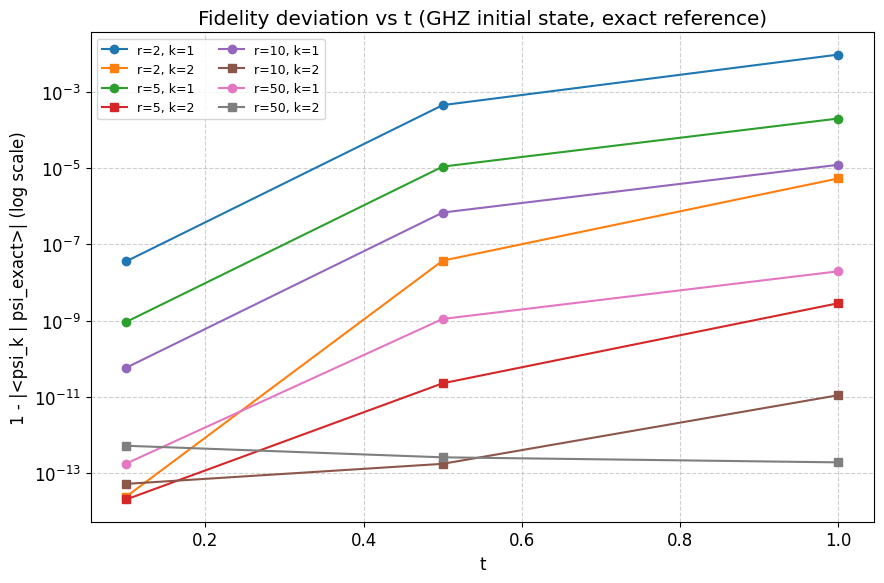


=== T3 summary (GHZ, exact reference) ===
r= 2, t= 0.1: log10(delta1/delta2) = +6.185  => k=2 closer
r= 2, t= 0.5: log10(delta1/delta2) = +4.089  => k=2 closer
r= 2, t= 1.0: log10(delta1/delta2) = +3.256  => k=2 closer
r= 5, t= 0.1: log10(delta1/delta2) = +4.667  => k=2 closer
r= 5, t= 0.5: log10(delta1/delta2) = +5.696  => k=2 closer
r= 5, t= 1.0: log10(delta1/delta2) = +4.855  => k=2 closer
r=10, t= 0.1: log10(delta1/delta2) = +3.052  => k=2 closer
r=10, t= 0.5: log10(delta1/delta2) = +6.606  => k=2 closer
r=10, t= 1.0: log10(delta1/delta2) = +6.057  => k=2 closer
r=50, t= 0.1: log10(delta1/delta2) = -0.469  => k=1 closer
r=50, t= 0.5: log10(delta1/delta2) = +3.638  => k=2 closer
r=50, t= 1.0: log10(delta1/delta2) = +5.023  => k=2 closer


In [32]:
# ---------------------------
# T3: GHZ state, full-matrix-exponential (no Trotter error) comparison
# Paste into a fresh notebook cell and run.
# ---------------------------
import time, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Try to import a reliable matrix exponential
try:
    from scipy.linalg import expm
except Exception as e:
    raise ImportError("scipy.linalg.expm required for exact evolution. Install scipy or run in an env with scipy.") from e

# --- user controls / reuse config from earlier cell ---
N = config.N            # number of qubits (uses SimConfig from earlier cell)
J = config.J
h = config.h
times = config.times    # list of times to evaluate e.g. [0.1,0.5,1.0]
ks = [1, 2]             # trotter orders to test (k=1 -> S2, k=2->S4)
r_list = [2, 5, 10, 50] # r values to inspect (assignment uses r=50)
shots = config.shots
seed = config.rng_seed

# --- build GHZ initial state vector (|00..0> + |11..1>)/sqrt(2) ---
dim = 2**N
zero_index = 0
one_index = dim - 1
psi0 = np.zeros((dim,), dtype=complex)
psi0[zero_index] = 1/np.sqrt(2)
psi0[one_index]  = 1/np.sqrt(2)

# --- build TFIM Hamiltonian as dense matrix (2^N x 2^N) ---
# H = J * sum_{j=1}^{N-1} Z_j Z_{j+1} + h * sum_j X_j
# We'll construct using sparse kron products but produce a dense array for expm.
def pauli_matrices():
    X = np.array([[0.,1.],[1.,0.]], dtype=complex)
    Z = np.array([[1.,0.],[0.,-1.]], dtype=complex)
    I = np.eye(2, dtype=complex)
    return I, X, Z

I2, X, Z = pauli_matrices()

def kron_n(list_of_ops):
    """Kronecker product for a list of small arrays (left-most is site 0)."""
    res = list_of_ops[0]
    for A in list_of_ops[1:]:
        res = np.kron(res, A)
    return res

# build Hamiltonian
start_h = time.time()
H = np.zeros((dim, dim), dtype=complex)

# Z_j Z_{j+1} terms
for j in range(N-1):
    ops = []
    for site in range(N):
        if site == j or site == j+1:
            ops.append(Z)
        else:
            ops.append(I2)
    H += J * kron_n(ops)

# X_j terms
for j in range(N):
    ops = []
    for site in range(N):
        ops.append(X if site == j else I2)
    H += h * kron_n(ops)

print(f"Built dense Hamiltonian H (dim={dim}) in {time.time()-start_h:.3f}s")

# --- helper: exact evolution via full matrix exponential ---
def exact_evolve_state(psi_in: np.ndarray, H: np.ndarray, t: float) -> np.ndarray:
    U = expm(-1j * H * t)    # exact unitary
    return U.dot(psi_in)

# --- containers for results ---
rows = []    # rows for dataframe: r, t, k, delta (1 - |<psi_k|psi_exact>|), exact_mag, approx_mag

# We'll reuse your Trotter circuit builder `create_trotter_unitary_circuit`
# and ghz preparation circuit `ghz_prep_circuit` if they are defined.

# sanity check: required helpers present
for name in ("create_trotter_unitary_circuit", "ghz_prep_circuit"):
    if name not in globals():
        raise RuntimeError(f"Required helper '{name}' not found in notebook globals. Please run previous cell that defines it.")

# GHZ prep circuit (already exists as function) - we only need the statevector, but we keep the circuit path consistent
ghz_prep = ghz_prep_circuit(N)
# compute psi_exact for each t (exact evolution of GHZ)
start_all = time.time()
for r in r_list:
    # temporarily override config.r for building Trotter circuits
    prev_r = config.r
    config.r = r

    for t in times:
        # exact state by full matrix exponential (no trotter) - THIS IS THE REFERENCE
        psi_exact = exact_evolve_state(psi0, H, t)
        exact_mag = 1.0  # psi_exact normalized by construction (we won't renormalize)
        # For each trotter order k, build U_{2k} with config.r slices and form psi_k = U_{2k} * GHZ
        for k in ks:
            # Build the trotter circuit (system-only) and apply to GHZ initial state
            circ_k = create_trotter_unitary_circuit(config, t, k=k)
            # create circuit that prepares GHZ and then applies trotter unitary
            combined = QuantumCircuit(N)
            combined.compose(ghz_prep, inplace=True)
            combined.compose(circ_k, inplace=True)
            # get statevector
            sv_k = Statevector.from_instruction(combined)
            psi_k = sv_k.data

            # fidelity overlap
            ov = np.vdot(psi_k, psi_exact)   # <psi_k | psi_exact>
            mag = abs(ov)
            delta = max(0.0, 1.0 - mag)      # small positive number
            rows.append({"r": r, "t": t, "k": k, "delta": delta, "mag": mag, "ov": ov})

    # restore config.r
    config.r = prev_r

print(f"Computed all (r,t,k) states in {time.time() - start_all:.3f}s")

# --- assemble DataFrame ---
df = pd.DataFrame(rows)
# pivot / convenience views
pivot = df.pivot_table(index=["r","t"], columns="k", values="delta").reset_index()
pivot.columns.name = None
pivot = pivot.rename(columns={1:"delta_k1", 2:"delta_k2"})
print("\nSummary (delta = 1 - |<psi_k|psi_exact>|):")
print(pivot.to_string(index=False, float_format="{:.3e}".format))

# --- Plot 1: fidelity deviation vs t (log scale) for each (r,k) ---
plt.figure(figsize=(9,6))
markers = {1:"o", 2:"s"}
colors = {2:"C0", 5:"C1", 10:"C2", 50:"C3"}
for r in r_list:
    for k in ks:
        sub = df[(df["r"]==r) & (df["k"]==k)].sort_values("t")
        ts = sub["t"].values
        dels = sub["delta"].values
        label = f"r={r}, k={k}"
        plt.plot(ts, dels, marker=markers[k], linestyle='-', label=label)
plt.yscale('log')
plt.xlabel('t')
plt.ylabel('1 - |<psi_k | psi_exact>| (log scale)')
plt.title('Fidelity deviation vs t (GHZ initial state, exact reference)')
plt.grid(True, which='both', ls='--', alpha=0.6)
plt.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()


# --- textual summary for report ---
print("\n=== T3 summary (GHZ, exact reference) ===")
for i, r in enumerate(r_list):
    for j, t in enumerate(times):
        val = ratios[i,j]
        closer = "k=2 closer" if val > 0 else "k=1 closer"
        print(f"r={r:2d}, t={t:>4}: log10(delta1/delta2) = {val:+.3f}  => {closer}")

# done
